In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
from healpy.visufunc import projplot
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, angular_separation, Angle
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole

### CMB dipole

In [3]:
cmb_amp, cmb_dir = dipole.cmb_dipole(frame='galactic')

### inputs

In [5]:
# kwargs for each catalog when instantiating a SecrestDipole() object
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits',
                      catname='catwise_agns', mag='w1', load_init=False)
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits',
                      catname='quaia', mag='G', load_init=False, compcorrect=True)

# parameter ranges
blims = np.arange(15, 71, 5)
factors = np.array([0., 0.2, 0.5, 1., 1.5, 2., 2.5])
w1lims = np.arange(15.7, 16.81, 0.1)
glims = np.arange(19., 20.51, 0.1)

# color maps
b_smap = mpl.cm.ScalarMappable(cmap='Blues', norm = mpl.colors.Normalize(vmin=min(blims), vmax=max(blims)))
r_smap = mpl.cm.ScalarMappable(cmap='Reds', norm = mpl.colors.Normalize(vmin=min(factors), vmax=max(factors)))
w1_smap = mpl.cm.ScalarMappable(cmap='Greens', norm = mpl.colors.Normalize(vmin=min(w1lims), vmax=max(w1lims)))
g_smap = mpl.cm.ScalarMappable(cmap='Greens',norm = mpl.colors.Normalize(vmin=min(glims), vmax=max(glims)))

#### load results

In [10]:
# galactic plane cuts
S21_dipoles_bcut = []
for i, blim in enumerate(blims):
    d = SecrestDipole(blim=blim, save_tag='', maglim=16.4, **catwise_kwargs)
    map_ = d.load_hpxelatcorr()
    S21_dipoles_bcut.append(d.compute_dipole(map_))
S21_dips_b = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in S21_dipoles_bcut
])
quaia_dipoles_bcut = []
for i, blim in enumerate(blims):
    d = SecrestDipole(blim=blim, save_tag='_r1.0', maglim=20., **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    quaia_dipoles_bcut.append(d.compute_dipole(map_))
quaia_dips_b = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in quaia_dipoles_bcut
])

In [22]:
# plane cut of interest
b_ = 40

In [23]:
# jackknife results with plane cut
# check 40deg plane cut too
res = np.load(f'/scratch/aew492/quasars/catalogs/catwise_agns/choices/jackknife_uncertainties_blims.npy',
              allow_pickle=True)
std_S21_fid = res[res[:,0]==30][:,1:].T.flatten()
std_S21_ = res[res[:,0]==b_][:,1:].T.flatten()
res = np.load(f'/scratch/aew492/quasars/catalogs/quaia/choices/jackknife_uncertainties_blims.npy',
              allow_pickle=True)
std_quaia_fid = res[res[:,0]==30][:,1:].T.flatten()
std_quaia_ = res[res[:,0]==b_][:,1:].T.flatten()

In [24]:
# fiducial results
ifid = (blims==30)
S21_fid = S21_dips_b[ifid].flatten()
quaia_fid = quaia_dips_b[ifid].flatten()

In [25]:
# another result
i = (blims==b_)
S21_ = S21_dips_b[i].flatten()
quaia_ = quaia_dips_b[i].flatten()

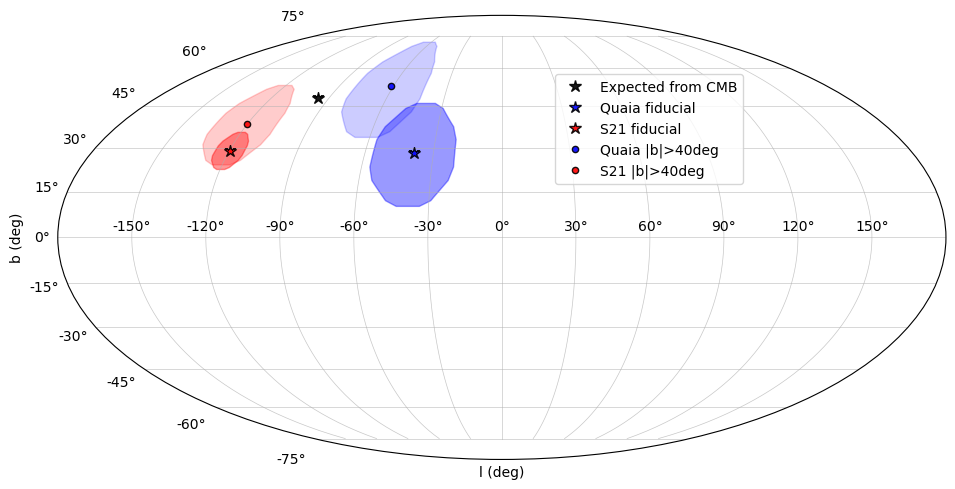

In [33]:
# sky plot
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection='mollweide')

kwargs = dict(ms=9, mec='k', ls='None', alpha=0.9)

# circles of uncertainty
circ = mpl.patches.Circle((Angle(quaia_fid[1]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(quaia_fid[2]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_quaia_fid[1]*u.deg).to(u.rad).value, color='b', alpha=0.4)
ax.add_artist(circ)
circ = mpl.patches.Circle((Angle(S21_fid[1]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(S21_fid[2]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_S21_fid[1]*u.deg).to(u.rad).value, color='r', alpha=0.4)
ax.add_artist(circ)
# 40deg
circ = mpl.patches.Circle((Angle(quaia_[1]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(quaia_[2]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_quaia_[1]*u.deg).to(u.rad).value, color='b', alpha=0.2)
ax.add_artist(circ)
circ = mpl.patches.Circle((Angle(S21_[1]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(S21_[2]*u.deg).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_S21_[1]*u.deg).to(u.rad).value, color='r', alpha=0.2)
ax.add_artist(circ)

# CMB
ax.plot(Angle(cmb_dir.l, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b, unit=u.rad).wrap_at(np.pi*u.rad),
        c='k', label='Expected from CMB', marker='*', **kwargs)
# Quaia fiducial
ax.plot(Angle(quaia_fid[1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(quaia_fid[2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='b', label='Quaia fiducial', marker='*', **kwargs)
# S21 fiducial
ax.plot(Angle(S21_fid[1]*u.deg).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(S21_fid[2]*u.deg).to(u.rad).wrap_at(np.pi*u.rad),
        c='r', label='S21 fiducial', marker='*', **kwargs)
# Quaia other result
ax.plot(Angle(quaia_[1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(quaia_[2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='b', label=f'Quaia |b|>{b_}deg', marker='.', **kwargs)
# S21 other result
ax.plot(Angle(S21_[1]*u.deg).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(S21_[2]*u.deg).to(u.rad).wrap_at(np.pi*u.rad),
        c='r', label=f'S21 |b|>{b_}deg', marker='.', **kwargs)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend(loc=(.56,.62))
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()